140.0 90.0
S--epoch:0    MAE:-3606.191650390625   Pure:90.25111325073242   ConLoss:-3696.4427636413575
epoch:0    MAE_test:63.2197939453125
S--epoch:1    MAE:-3707.04303515625   Pure:52.60738534545899   ConLoss:-3759.650420501709
epoch:1    MAE_test:54.9541863861084
S--epoch:2    MAE:-3756.31166015625   Pure:24.052025741577147   ConLoss:-3780.363685897827
epoch:2    MAE_test:25.33960775756836
S--epoch:3    MAE:-3764.33809375   Pure:22.808102233886718   ConLoss:-3787.1461959838866
epoch:3    MAE_test:24.470404296875
S--epoch:4    MAE:-3749.70928515625   Pure:18.467624809265136   ConLoss:-3768.1769099655153
epoch:4    MAE_test:15.379315963745118
S--epoch:5    MAE:-3749.287046875   Pure:16.95445833206177   ConLoss:-3766.241505207062
epoch:5    MAE_test:29.508266147613526
S--epoch:6    MAE:-3757.807017578125   Pure:19.956457916259765   ConLoss:-3777.7634754943847
epoch:6    MAE_test:25.512694931030275
S--epoch:7    MAE:-3775.129232421875   Pure:18.4520532913208   ConLoss:-3793.581285713196

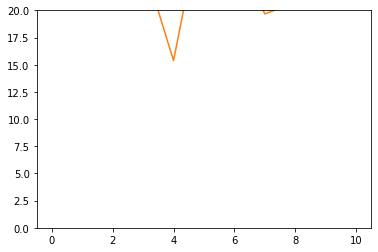

S--epoch:11    MAE:-3739.227990234375   Pure:17.765237815856935   ConLoss:-3756.993228050232
epoch:11    MAE_test:20.271504150390626
S--epoch:12    MAE:-3757.86533984375   Pure:17.848127914428712   ConLoss:-3775.713467758179
epoch:12    MAE_test:25.67187934875488
S--epoch:13    MAE:-3710.15475390625   Pure:20.19701374053955   ConLoss:-3730.3517676467895
epoch:13    MAE_test:38.1838843460083
S--epoch:14    MAE:-3721.63012109375   Pure:19.606680671691894   ConLoss:-3741.2368017654417
epoch:14    MAE_test:19.699940658569336
S--epoch:15    MAE:-3737.224853515625   Pure:18.63031726837158   ConLoss:-3755.8551707839965
epoch:15    MAE_test:25.04617349243164
S--epoch:16    MAE:-3590.908740234375   Pure:13.634353546142577   ConLoss:-3604.5430937805177
epoch:16    MAE_test:12.832940864562989


KeyboardInterrupt: 

In [1]:
import torch.optim as optim
from dataset import *
from model import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

train_log = np.array([])
test_log = np.array([])
lambda_contrast = 2000

criterion = nn.L1Loss()
criterion = criterion.cuda()

model = VGG_contrast().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

tmp = np.load("../data/simu_20000_0.1_90_140_train.npy")
max = np.max(tmp[:, 1004])
min = np.min(tmp[:, 1004])
print(max, min)

train_dataset = Dataset("../data/simu_20000_0.1_90_140_train.npy", 0, 0)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = Dataset("../data/simu_10000_0.1_90_140_resonance_morlet.npy", 0, 1)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for epoch in range(500):
    model.train()

    loss_ERM_total = 0
    step = 0
    loss_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        output, features = model(data)
        
        loss_ERM = criterion(output, target)
        loss_contrastive_total = 0
        loss_ERM_total += loss_ERM.item()
        
        # if batch_idx%10:
        #     print("%d"%(batch_idx))

        # for sp
        sp_diff = []
        feature_dis = []
        sp_contrastive_loss = 0.0
        sp_contrastive_loss = torch.tensor(sp_contrastive_loss, requires_grad=True)

        for i in range(len(target[:, 0, 0]) - 1):
            for j in range(i + 1, len(target[:, 0, 0])):
                diff = torch.abs(target[i, 0, 0] - target[j, 0, 0])
                sp_diff.append(diff)
                dis = torch.sum(features[i, :, :] * features[j, :, :]) / (
                            torch.norm(features[i, :, :]) * torch.norm(features[j, :, :]))
                feature_dis.append(torch.exp(dis))
            sorted_id_diff = sorted(range(len(sp_diff)), key=lambda k: sp_diff[k])

            sorted_feature_dis = []
            for k in range(len(sorted_id_diff)):
                sorted_feature_dis.append(feature_dis[sorted_id_diff[k]])

            temp_sp_loss = torch.tensor(0.0, requires_grad=True)

            for p in range(len(sorted_feature_dis) - 1):
                sum = torch.tensor(0.0, requires_grad=True)
                for q in range(p + 1, len(sorted_feature_dis)):
                    sum = sum + sorted_feature_dis[q]
                temp_sp_loss = temp_sp_loss + torch.log(sorted_feature_dis[p]) - torch.log(sum)
            temp_sp_loss = temp_sp_loss / (len(sorted_feature_dis) - 1)

            sp_contrastive_loss = sp_contrastive_loss + temp_sp_loss

            sp_diff = sp_diff[:i + 1]

            feature_dis = feature_dis[:i + 1]

        sp_contrastive_loss = sp_contrastive_loss / (len(target[:, 0, 0]) - 1)

        # print(loss)
        # print(sp_contrastive_loss)
        loss_contrastive_total += sp_contrastive_loss.item()

        loss = loss_ERM + sp_contrastive_loss * lambda_contrast
              
        optimizer.zero_grad()
        # sp_contrastive_loss.backward()
        loss.backward()
        optimizer.step()

        loss_total = loss_total + loss.item()
        step = step + 1

    tmp = './pth/S_model_%d_%.4f.pth' % (epoch, loss_total/step)
    if epoch % 10 == 0:
        torch.save(model, tmp)
    print("S--epoch:" + str(epoch) + "    MAE:" + str(loss_total/step) + "   Pure:" + str(loss_ERM_total/step) + "   ConLoss:"+ str((loss_total-loss_ERM_total)/step))
    train_log = np.append(train_log, loss_total/step)

    loss_test = 0
    step = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output, features = model(data)


            loss = criterion(output, target)

            loss_test = loss_test + loss.item()
            step = step + 1

        loss_mean = loss_test / step
        print("epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
        test_log = np.append(test_log, loss_mean)
    
    if epoch % 10 == 0 and epoch != 0:
        print("Test_epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
        # tmp_epoch = np.arange(epoch+1)
        # print(tmp_epoch)
        # print(next(model.OneToOneLayer.parameters()))
        plt.plot(train_log)
        plt.plot(test_log)
        plt.ylim(0,20)
        plt.show()